In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from skimage.transform import resize

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
ids_test = load_array("data/array/ids_test")
X_test = load_array("data/array/X_test")

In [4]:
model = load_model('models/07-30/unet2-04.model', custom_objects={'mean_iou': mean_iou})

In [5]:
pred_test = model.predict(X_test, verbose=1)

18000/18000 [==============================] - 19s 1ms/step


## Downsample and sanity check

In [6]:
threshold = 0.55

In [7]:
preds_test_downsample = np.zeros((pred_test.shape[0], OR_IM_HEIGHT, OR_IM_WIDTH, OR_IM_CHANNEL), dtype=np.uint8)

In [8]:
# Resize it back to original size: 101x101
for i in tqdm.tnrange(len(pred_test)):
    preds_test_downsample[i] = np.uint8(downsample(pred_test[i]))

In [9]:
pred_test_tresh = np.int32(pred_test > threshold)

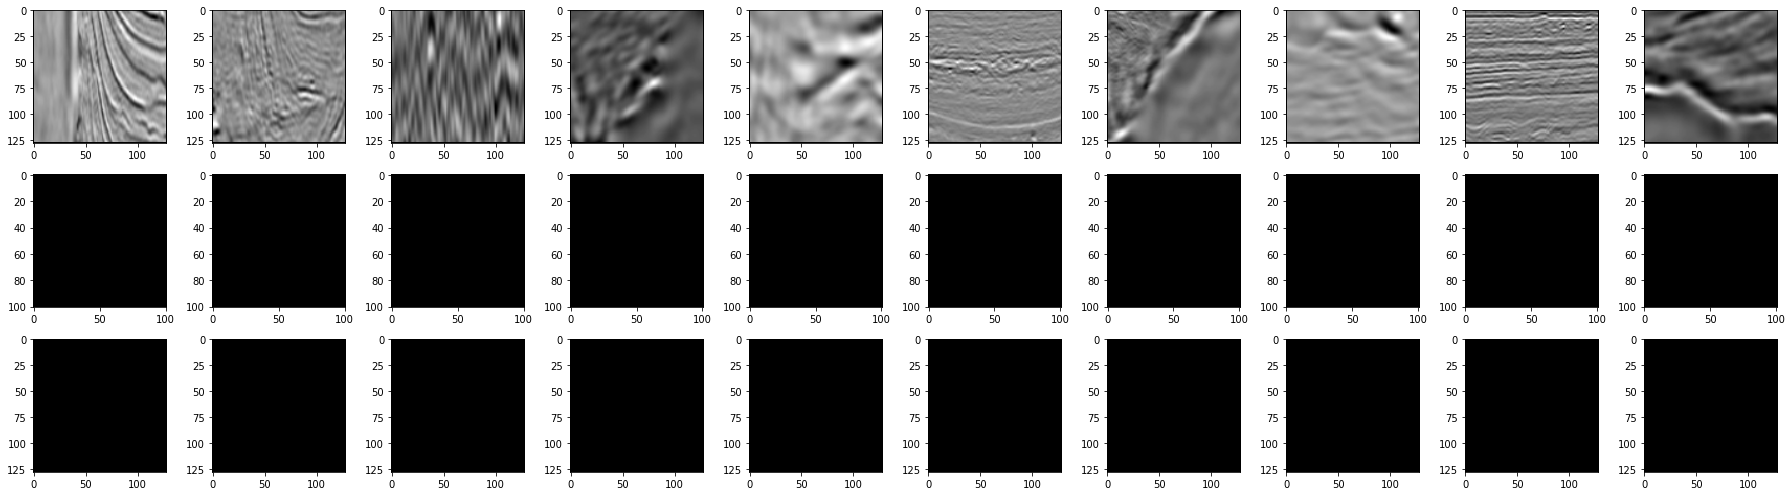

In [10]:
plot_arrays(X_test, preds_test_downsample, pred_test_tresh, n=10, figsize=(25, 7))

## Create submission

Here we downsample first and then do the treshold mask again

In [11]:
pred_dict = {img_id: rle_encode(preds_test_downsample[i]) for i, img_id in tqdm.tqdm_notebook(enumerate(ids_test), total=len(ids_test))}

In [12]:
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

In [13]:
sub.head()

,rle_mask
id,
0005bb9630,NaN
000a68e46c,NaN
000c8dfb2a,NaN
000d0a5f6c,NaN
001ef8fc87,NaN


In [14]:
sub.to_csv('submission.csv')

In [15]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "Unet - epoch 10 - loss: 0.3654 - mean_iou: 0.3841 - val_loss: 0.3601 - val_mean_iou: 0.3873 - threshold=0.55"

Successfully submitted to TGS Salt Identification Challenge